In [1]:
import spotipy, pandas as pd, json, numpy as np
from spotipy.oauth2 import SpotifyOAuth
from sklearn import preprocessing as pre
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations, permutations
import sys

if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [2]:
scope = 'playlist-modify-public playlist-modify-private'
red_url = 'http://localhost:8080'
#playlist = 'https://open.spotify.com/playlist/37i9dQZEVXcD0rEV1cHpue?si=cba0a3fd1e1a47b4' #Discover Weekly
playlist = 'https://open.spotify.com/playlist/0zZlkqz8ZRPsZd0kARwia9?si=2b1315ae6d884cb5' # big test playlist

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(redirect_uri=red_url,scope=scope))
user = sp.me()['id']

In [3]:
offset = 0
song_ids = []
while True:
    songs = sp.playlist_tracks(playlist_id=playlist, offset=offset, fields='items.track.id', limit=100)['items']
    if len(songs) == 0:
        break
    song_ids += [d['track']['id'] for d in songs]
    offset += len(songs)

In [4]:
offset = 0
limit = 50
song_feats = []
while offset < len(song_ids):
    song_feats += sp.audio_features(tracks=song_ids[offset: offset + limit])
    offset += limit

In [5]:
# aud_anal = []
# aud_secs = []
# j = 0
# for song in song_ids:
#     track = sp.audio_analysis(song_ids[j])
#     dur = track['track']['duration']
#     secs = len(track['sections'])
#     aud_anal.append(track)
#     aud_secs.append(60*secs/dur)
#     j += 1

In [6]:
df_feats = pd.DataFrame(song_feats).drop(['type', 'uri', 'track_href', 'analysis_url', 'duration_ms', 'key', 'time_signature'], axis=1)
# df_aud = pd.DataFrame(aud_anal)[['tempo_confidence','time_signature_confidence','key_confidence','mode_confidence']]
# df_secs = pd.DataFrame({'secs/min': aud_secs})

In [7]:
#df_dummies = pd.get_dummies(df_feats[['key', 'time_signature']], columns=['key', 'time_signature'], drop_first=True)

In [8]:
to_norm = df_feats[['loudness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'liveness']].values
scaler = pre.MinMaxScaler()
normed = scaler.fit_transform(to_norm)
df_normed = pd.DataFrame(normed).rename(columns={0: 'loudness', 1: 'tempo', 2: 'speechiness', 3: 'acousticness', 4: 'instrumentalness', 5: 'liveness'})

In [9]:
df_feats.drop(['loudness', 'tempo', 'speechiness', 'acousticness', 'instrumentalness', 'liveness'], axis=1, inplace=True)

In [10]:
df_total = df_feats.join(df_normed)
df_feats = df_total.set_index('id')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


<AxesSubplot:>

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Liberation Sans, Bitstream Vera Sans, sans-serif


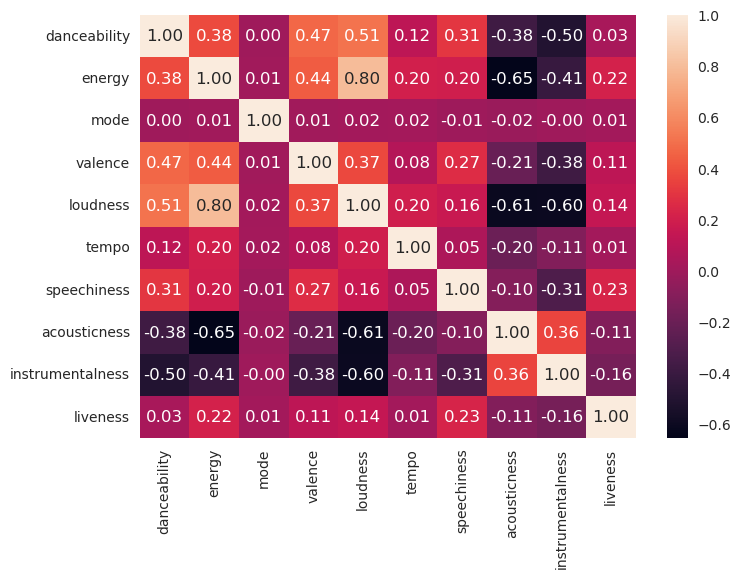

In [11]:
sns.heatmap(df_feats.corr(), annot=True, fmt='.2f')

In [12]:
# df_feats.drop(['loudness', 'acousticness'], axis=1, inplace=True)

In [13]:
# df_feats.head()

In [14]:
# sns.heatmap(df_feats.corr(), annot=True, fmt='.2f')

In [15]:
# n_clusters = [2, 3, 4, 5, 6]
# cluster_scores = []
# for n in n_clusters:
#     clusters = KMeans(n_clusters=n)
#     labs = clusters.fit_predict(df_feats.values)
#     sil_avg = silhouette_score(df_feats.values, labs)
#     cluster_scores.append(sil_avg)

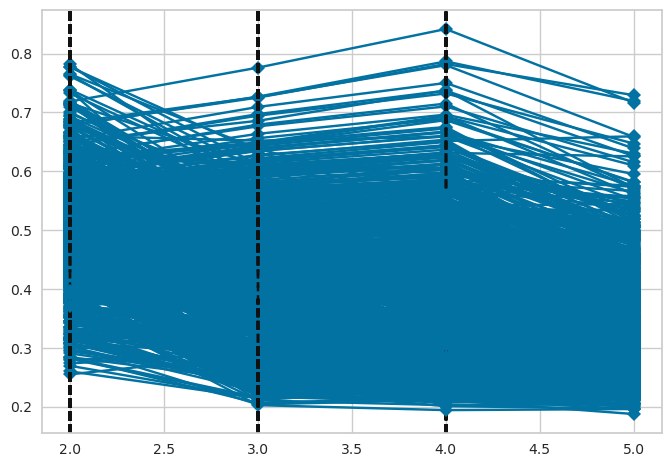

In [16]:
n_clusters = [2, 3, 4, 5, 6]
cols = list(df_feats)
feats = 3
combo, score, value = [], [], []
while feats <= len(cols):
    combos = list(combinations(cols, feats))
    combo += combos
    for comb in combos:
        subset = df_feats[list(comb)]
        model = KElbowVisualizer(KMeans(), k=(min(n_clusters), max(n_clusters)), metric='silhouette', timings=False)
        model.fit(subset.values)
        score.append(model.elbow_score_)
        value.append(model.elbow_value_)
    feats += 1
    
output = {'combo': combo, 'score': score, 'value': value}
df_combos = pd.DataFrame(output)

In [17]:
df_options = df_combos[(df_combos['value'] >= 3) & (df_combos['score'] > 0.6)]

In [18]:
df_options

,combo,score,value
13,"(danceability, mode, instrumentalness)",0.750163,4.0
41,"(energy, mode, instrumentalness)",0.710375,4.0
68,"(mode, valence, instrumentalness)",0.696338,4.0
73,"(mode, loudness, instrumentalness)",0.841812,4.0
77,"(mode, tempo, instrumentalness)",0.780414,4.0
80,"(mode, speechiness, instrumentalness)",0.786776,4.0
84,"(mode, instrumentalness, liveness)",0.782398,4.0
157,"(danceability, mode, loudness, instrumentalness)",0.679401,3.0
168,"(danceability, mode, instrumentalness, liveness)",0.640093,3.0
213,"(energy, mode, loudness, instrumentalness)",0.656283,3.0


In [23]:
df_feats_cluster = df_feats[['danceability', 'mode', 'instrumentalness']]
df_total_cluster = df_total[['id','danceability', 'mode', 'instrumentalness']]

In [24]:
num_clusts = 4
mod = KMeans(n_clusters=num_clusts).fit(df_feats_cluster.values)

In [25]:
clusters = {'cluster': mod.labels_}
df_clustered = df_total_cluster.join(pd.DataFrame(clusters))

In [26]:
for i in range(num_clusts):
    songs = list(df_clustered['id'][df_clustered['cluster'] == i])
    name = f'created_playlist_{i}'
    current_playlists = []
    offset = 0
    while True:
        playlists = sp.current_user_playlists(limit=50, offset=offset)['items']
        if len(playlists) == 0:
            break
        current_playlists += [d['name'] for d in playlists]
        offset += len(playlists)
    if name in current_playlists:
        continue
    sp.user_playlist_create(user=user, name=name)
    new = sp.current_user_playlists(limit=1)['items'][0]['uri']
    if len(songs) > 100:
        j = 0
        while j < (len(songs)//100 + 1):
            sub_songs = songs[100*j:100*(1+j)]
            sp.user_playlist_add_tracks(user=user, playlist_id=new, tracks=sub_songs)
            j += 1
        sp.user_playlist_add_tracks(user=user, playlist_id=new, tracks=songs[-(len(songs)%100):])
    else:
        sp.user_playlist_add_tracks(user=user, playlist_id=new, tracks=songs)